In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.

#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数

beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0.5
prior=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


tensor(0.2228, dtype=torch.float64)

tensor(0.2055, dtype=torch.float64)

tensor(0.2209, dtype=torch.float64)

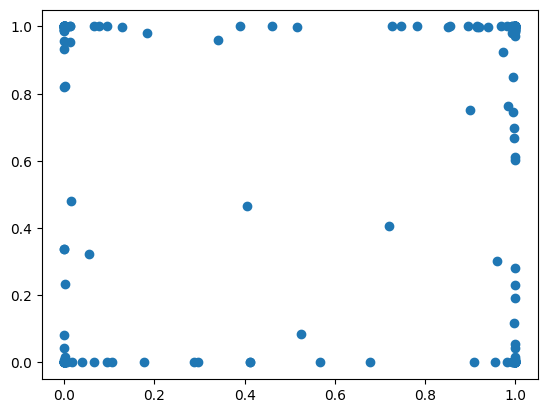

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)

plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()


tensor(0.2228, dtype=torch.float64)

tensor(0.2055, dtype=torch.float64)

tensor(0.2209, dtype=torch.float64)

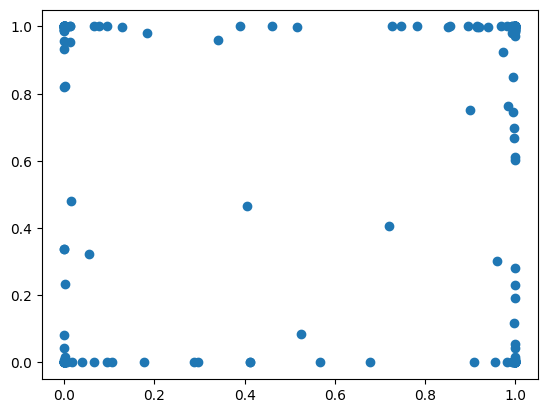

In [4]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

In [5]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [6]:
################## first step##################

#0.6,0.3
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)


    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr = config["lambda1"], config["lambda2"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
#         test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
#         test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
#         test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)


        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lr":tune.choice([0.6,0.7,0.8])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=30)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-11-15 15:45:06,565	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-11-15 15:45:07,437	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_6cbf6_00000,TERMINATED,10.224.0.12:9122,0.05,0.003,0.6,1,15.1123,0.874168
train_model_6cbf6_00001,TERMINATED,10.224.0.12:9149,0.03,0.003,0.6,1,13.9161,0.868032
train_model_6cbf6_00002,TERMINATED,10.224.0.12:9151,0.04,0.002,0.8,1,14.3883,0.881237
train_model_6cbf6_00003,TERMINATED,10.224.0.12:9153,0.05,0.002,0.6,1,14.4887,0.878524
train_model_6cbf6_00004,TERMINATED,10.224.0.12:9154,0.05,0.003,0.8,1,14.1847,0.884915
train_model_6cbf6_00005,TERMINATED,10.224.0.12:9155,0.04,0.003,0.6,1,14.8089,0.870605
train_model_6cbf6_00006,TERMINATED,10.224.0.12:9158,0.03,0.002,0.6,1,14.2941,0.862809
train_model_6cbf6_00007,TERMINATED,10.224.0.12:9160,0.03,0.003,0.6,1,13.3292,0.868032
train_model_6cbf6_00008,TERMINATED,10.224.0.12:9162,0.04,0.001,0.6,1,15.0891,0.875624
train_model_6cbf6_00009,TERMINATED,10.224.0.12:9164,0.05,0.003,0.8,1,14.0074,0.884915


(raylet) [2022-11-15 15:45:16,446 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137928704; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_6cbf6_00000:
  date: 2022-11-15_15-45-24
  done: false
  experiment_id: 987e7e61aa804705a031ca995d815109
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8741682903660262
  node_ip: 10.224.0.12
  pid: 9122
  time_since_restore: 15.112344026565552
  time_this_iter_s: 15.112344026565552
  time_total_s: 15.112344026565552
  timestamp: 1668498324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6cbf6_00000
  warmup_time: 0.003550291061401367
  
Result for train_model_6cbf6_00000:
  date: 2022-11-15_15-45-24
  done: true
  experiment_id: 987e7e61aa804705a031ca995d815109
  experiment_tag: 0_lambda1=0.0500,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8741682903660262
  node_ip: 10.224.0.12
  pid: 9122
  time_since_restore: 15.112344026565552
  time_this_iter_s: 15.112344026565552
  time_total_s: 15.112344026565552
  timestamp: 1668498324
  timesteps_since_res

(raylet) [2022-11-15 15:45:26,453 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137846784; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_6cbf6_00007:
  date: 2022-11-15_15-45-26
  done: false
  experiment_id: d0a1484cf6a44c63a605b594d3d3f999
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8680317761909988
  node_ip: 10.224.0.12
  pid: 9160
  time_since_restore: 13.329214096069336
  time_this_iter_s: 13.329214096069336
  time_total_s: 13.329214096069336
  timestamp: 1668498326
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6cbf6_00007
  warmup_time: 0.005710124969482422
  
Result for train_model_6cbf6_00007:
  date: 2022-11-15_15-45-26
  done: true
  experiment_id: d0a1484cf6a44c63a605b594d3d3f999
  experiment_tag: 7_lambda1=0.0300,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8680317761909988
  node_ip: 10.224.0.12
  pid: 9160
  time_since_restore: 13.329214096069336
  time_this_iter_s: 13.329214096069336
  time_total_s: 13.329214096069336
  timestamp: 1668498326
  timesteps_since_res

Result for train_model_6cbf6_00028:
  date: 2022-11-15_15-45-27
  done: false
  experiment_id: 503eb0db1123447a9b0afa7f8e13fe3d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792931613010699
  node_ip: 10.224.0.12
  pid: 9202
  time_since_restore: 14.082062005996704
  time_this_iter_s: 14.082062005996704
  time_total_s: 14.082062005996704
  timestamp: 1668498327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6cbf6_00028
  warmup_time: 0.006128072738647461
  
Result for train_model_6cbf6_00002:
  date: 2022-11-15_15-45-27
  done: false
  experiment_id: 10ebf7bbb8ed41ada01b35c1f505b082
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8812365361132523
  node_ip: 10.224.0.12
  pid: 9151
  time_since_restore: 14.388335943222046
  time_this_iter_s: 14.388335943222046
  time_total_s: 14.388335943222046
  timestamp: 1668498327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6cbf6_00002
  w

Result for train_model_6cbf6_00008:
  date: 2022-11-15_15-45-27
  done: false
  experiment_id: 9ab7d83be9904438933b8c295f74a731
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8756241525184378
  node_ip: 10.224.0.12
  pid: 9162
  time_since_restore: 15.089051961898804
  time_this_iter_s: 15.089051961898804
  time_total_s: 15.089051961898804
  timestamp: 1668498327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6cbf6_00008
  warmup_time: 0.005678892135620117
  
Result for train_model_6cbf6_00008:
  date: 2022-11-15_15-45-27
  done: true
  experiment_id: 9ab7d83be9904438933b8c295f74a731
  experiment_tag: 8_lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8756241525184378
  node_ip: 10.224.0.12
  pid: 9162
  time_since_restore: 15.089051961898804
  time_this_iter_s: 15.089051961898804
  time_total_s: 15.089051961898804
  timestamp: 1668498327
  timesteps_since_res

2022-11-15 15:45:29,287	INFO tune.py:758 -- Total run time: 21.85 seconds (21.67 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
6cbf6_00000         0.874168         15.112344  True            None   
6cbf6_00001         0.868032         13.916126  True            None   
6cbf6_00002         0.881237         14.388336  True            None   
6cbf6_00003         0.878524         14.488715  True            None   
6cbf6_00004         0.884915         14.184676  True            None   
6cbf6_00005         0.870605         14.808888  True            None   
6cbf6_00006         0.862809         14.294140  True            None   
6cbf6_00007         0.868032         13.329214  True            None   
6cbf6_00008         0.875624         15.089052  True            None   
6cbf6_00009         0.884915         14.007393  True            None   
6cbf6_00010         0.884686         14.232310  True            None   
6cbf6_

(raylet) [2022-11-15 15:45:36,462 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137273344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:45:46,480 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137293824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:45:56,491 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137289728; capacity: 29394726912. Object creation will fail if spilling is required.


In [7]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation loss: 0.8865835092498143


{'lambda1': 0.05, 'lambda2': 0.001, 'lr': 0.8}

(raylet) [2022-11-15 15:46:06,502 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137269248; capacity: 29394726912. Object creation will fail if spilling is required.


In [8]:
################## second step##################
################## training stage ##################

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1381, grad_fn=<AddBackward0>)

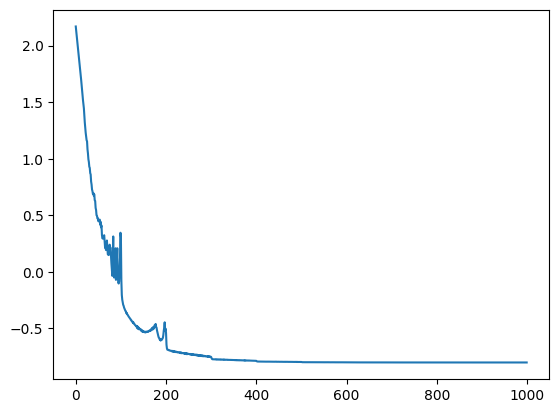

In [9]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [10]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.4685e-01, -1.9006e-01, -2.0726e-01, -9.6977e-02, -1.1551e-01,
         -3.7023e-06, -2.0905e-01, -1.3803e-01, -2.2462e-01,  1.9844e-01,
          6.6748e-07,  3.2655e-06, -2.1500e-06,  2.2101e-06,  1.9425e-06,
         -2.8961e-07,  2.7949e-06, -5.1139e-06, -5.6837e-07,  3.6516e-06,
          7.6645e-07, -3.8110e-07,  1.1733e-07,  2.1598e-03,  4.8843e-06,
         -1.4404e-06, -1.3183e-06,  1.1936e-06, -1.2091e-07,  3.1303e-07,
          1.7072e-07, -2.5743e-06,  9.3845e-07, -2.4892e-06,  2.3520e-06,
         -2.2186e-06,  1.5638e-06,  2.4111e-06, -2.8710e-06,  6.0296e-07,
          6.5226e-07, -2.8133e-06,  3.1323e-06,  1.0208e-06,  1.6171e-01,
          9.2824e-07,  2.8802e-07, -1.8426e-06, -3.8714e-07,  3.5581e-06,
         -2.2437e-06, -2.6027e-06,  4.0488e-06, -4.3332e-07,  3.0805e-06,
          3.6385e-02, -1.8095e-06, -4.4747e-07, -2.1158e-06,  1.0461e-06,
          2.8842e-06, -6.8235e-07, -3.9531e-06,  9.6160e-07,  2.9574e-07,
         -3.3670e-06, -1.3022e-07,  4.

tensor([[-1.4685e-01, -1.9006e-01, -2.0726e-01, -9.6977e-02, -1.1551e-01,
         -3.7023e-06, -2.0905e-01, -1.3803e-01, -2.2462e-01,  1.9844e-01,
          6.6748e-07,  3.2655e-06, -2.1500e-06,  2.2101e-06,  1.9425e-06,
         -2.8961e-07,  2.7949e-06, -5.1139e-06, -5.6837e-07,  3.6516e-06,
          7.6645e-07, -3.8110e-07,  1.1733e-07,  2.1598e-03,  4.8843e-06,
         -1.4404e-06, -1.3183e-06,  1.1936e-06, -1.2091e-07,  3.1303e-07,
          1.7072e-07, -2.5743e-06,  9.3845e-07, -2.4892e-06,  2.3520e-06,
         -2.2186e-06,  1.5638e-06,  2.4111e-06, -2.8710e-06,  6.0296e-07,
          6.5226e-07, -2.8133e-06,  3.1323e-06,  1.0208e-06,  1.6171e-01,
          9.2824e-07,  2.8802e-07, -1.8426e-06, -3.8714e-07,  3.5581e-06,
         -2.2437e-06, -2.6027e-06,  4.0488e-06, -4.3332e-07,  3.0805e-06,
          3.6385e-02, -1.8095e-06, -4.4747e-07, -2.1158e-06,  1.0461e-06,
          2.8842e-06, -6.8235e-07, -3.9531e-06,  9.6160e-07,  2.9574e-07,
         -3.3670e-06, -1.3022e-07,  4.

tensor([[-1.6908e-01,  2.1636e-01, -3.0844e-01, -1.5965e-01,  2.0187e-01,
          7.4145e-08, -2.0253e-01, -1.9880e-01, -2.5344e-01, -2.7564e-01,
          3.3583e-07, -5.0932e-07,  9.0789e-08,  7.7358e-07, -1.5490e-08,
          4.0731e-07,  3.0271e-08,  1.1754e-06,  2.1325e-07,  3.6051e-07,
          3.2401e-08,  7.6329e-08, -4.6575e-08,  7.6494e-02,  3.7242e-07,
         -4.7441e-08, -2.2013e-06, -1.3423e-06,  6.7768e-09, -1.4368e-07,
         -2.1325e-06, -7.2247e-07, -3.1815e-07,  5.1027e-08, -1.3164e-07,
          2.2494e-07,  1.5482e-08,  8.9669e-07,  9.2240e-08, -3.5314e-08,
         -3.8556e-08, -8.4438e-09,  3.9518e-09, -4.4596e-07,  7.7357e-02,
         -1.8293e-07, -1.2274e-07,  1.2044e-07, -5.6033e-07, -1.0830e-07,
         -3.7822e-07,  9.8568e-08,  3.2959e-07, -3.5171e-07,  6.7473e-08,
          1.2986e-01, -3.7709e-08,  9.6286e-07, -1.1968e-07, -1.9303e-07,
         -8.6060e-07, -1.8901e-08, -1.2236e-06, -1.1675e-07, -8.1182e-08,
          1.1049e-08, -1.3126e-07, -3.

(raylet) [2022-11-15 15:46:16,512 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137256960; capacity: 29394726912. Object creation will fail if spilling is required.


In [11]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[40, 10],
       [ 8, 62]])

0.8857142857142857

0.8

0.85

0.8611111111111112

0.8732394366197184

(raylet) [2022-11-15 15:46:26,522 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137248768; capacity: 29394726912. Object creation will fail if spilling is required.


In [12]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[13,  2],
       [ 3, 22]])

0.88

0.8666666666666667

array([[13,  5],
       [ 4, 18]])

0.8181818181818182

0.7222222222222222

array([[14,  3],
       [ 1, 22]])

0.9565217391304348

0.8235294117647058

In [13]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.46852195e-01, -1.90057307e-01, -2.07261398e-01,
        -9.69767943e-02, -1.15507506e-01, -3.70229964e-06,
        -2.09049836e-01, -1.38033241e-01, -2.24617466e-01,
         1.98438480e-01,  6.67482595e-07,  3.26551276e-06,
        -2.14996157e-06,  2.21013829e-06,  1.94247968e-06,
        -2.89606703e-07,  2.79487222e-06, -5.11386361e-06,
        -5.68370638e-07,  3.65161395e-06,  7.66454093e-07,
        -3.81095305e-07,  1.17326010e-07,  2.15982809e-03,
         4.88429987e-06, -1.44041553e-06, -1.31831155e-06,
         1.19361005e-06, -1.20912560e-07,  3.13027329e-07,
         1.70722643e-07, -2.57430770e-06,  9.38447272e-07,
        -2.48921629e-06,  2.35202447e-06, -2.21859023e-06,
         1.56378314e-06,  2.41110479e-06, -2.87095759e-06,
         6.02955936e-07,  6.52263225e-07, -2.81329653e-06,
         3.13227906e-06,  1.02076569e-06,  1.61711469e-01,
         9.28241604e-07,  2.88015229e-07, -1.84263752e-06,
        -3.87135572e-07,  3.55805400e-06, -2.24365408e-0

array([[-1.46852195e-01, -1.90057307e-01, -2.07261398e-01,
        -9.69767943e-02, -1.15507506e-01, -3.70229964e-06,
        -2.09049836e-01, -1.38033241e-01, -2.24617466e-01,
         1.98438480e-01,  6.67482595e-07,  3.26551276e-06,
        -2.14996157e-06,  2.21013829e-06,  1.94247968e-06,
        -2.89606703e-07,  2.79487222e-06, -5.11386361e-06,
        -5.68370638e-07,  3.65161395e-06,  7.66454093e-07,
        -3.81095305e-07,  1.17326010e-07,  2.15982809e-03,
         4.88429987e-06, -1.44041553e-06, -1.31831155e-06,
         1.19361005e-06, -1.20912560e-07,  3.13027329e-07,
         1.70722643e-07, -2.57430770e-06,  9.38447272e-07,
        -2.48921629e-06,  2.35202447e-06, -2.21859023e-06,
         1.56378314e-06,  2.41110479e-06, -2.87095759e-06,
         6.02955936e-07,  6.52263225e-07, -2.81329653e-06,
         3.13227906e-06,  1.02076569e-06,  1.61711469e-01,
         9.28241604e-07,  2.88015229e-07, -1.84263752e-06,
        -3.87135572e-07,  3.55805400e-06, -2.24365408e-0

array([[-1.6907963e-01,  2.1636228e-01, -3.0844453e-01, -1.5965073e-01,
         2.0186695e-01,  7.4145461e-08, -2.0253460e-01, -1.9880275e-01,
        -2.5343829e-01, -2.7563876e-01,  3.3582930e-07, -5.0931936e-07,
         9.0788710e-08,  7.7358408e-07, -1.5489526e-08,  4.0731086e-07,
         3.0271018e-08,  1.1754292e-06,  2.1324558e-07,  3.6051230e-07,
         3.2400930e-08,  7.6329307e-08, -4.6575259e-08,  7.6494403e-02,
         3.7241603e-07, -4.7441045e-08, -2.2013357e-06, -1.3422703e-06,
         6.7768346e-09, -1.4368199e-07, -2.1324608e-06, -7.2246678e-07,
        -3.1815361e-07,  5.1027250e-08, -1.3164482e-07,  2.2494459e-07,
         1.5481739e-08,  8.9668936e-07,  9.2240008e-08, -3.5313811e-08,
        -3.8555797e-08, -8.4437612e-09,  3.9518375e-09, -4.4596229e-07,
         7.7357471e-02, -1.8292555e-07, -1.2273787e-07,  1.2044143e-07,
        -5.6033304e-07, -1.0830008e-07, -3.7822031e-07,  9.8568336e-08,
         3.2959130e-07, -3.5170862e-07,  6.7473344e-08,  1.29858

In [14]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.1468522 , -0.19005731, -0.2072614 , -0.09697679, -0.11550751,
         0.        , -0.20904984, -0.13803324, -0.22461747,  0.19843848,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.16171147,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.036385  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 45, 56, 71, 91, 95])

14

(raylet) [2022-11-15 15:46:36,533 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137244672; capacity: 29394726912. Object creation will fail if spilling is required.


In [15]:
index=np.nonzero(model_1_weight)[1]
index=index.tolist()
index=set(index)

beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)

TP=len(trueindex.intersection(index))
FP=len(index.difference(trueindex))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

0.9

0.9444444444444444

0.9219544457292888

0.94

(raylet) [2022-11-15 15:46:46,543 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137244672; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:46:56,553 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 137244672; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:47:06,564 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 138706944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:47:16,575 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 152932352; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-11-15 15:51:56,872 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322277376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:52:06,883 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322252800; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:52:16,893 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322244608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:52:26,903 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322244608; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-11-15 15:57:07,209 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322023424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:57:17,220 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322019328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:57:27,231 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322019328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 15:57:37,242 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 322015232; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-11-15 16:02:17,543 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 321785856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 16:02:27,554 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 321781760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 16:02:37,564 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 321781760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-15 16:02:47,575 E 8217 8235] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-15_15-45-05_436790_8090 is over 95% full, available space: 321781760; capacity: 29394726912. Object creation will fail if spilling i